In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
#Parameters
batch_size = 16
accurate_loss_baseline = 1e-6

# Paths
path = "solutions"
training_data_path = "2D_LatentSpace_Prediction_results/LatentSpace_Prediction_trainingData_Gadi.txt"
model_path = "2D_LatentSpace_Prediction_results/latent_space_model_best_Gadi.pth"
encoder_path = "2D_ConvAE_results/Conv2D_encoder_best_Gadi.pth"
decoder_path = "2D_ConvAE_results/Conv2D_decoder_best_Gadi.pth"

In [3]:
# Temperature for the two consecutive timestamp
temperature_fields_input = []
temperature_fields_output = []
  
# Read text File  
def read_text_file(file_path):
    with h5py.File(file_path, 'r') as f:
        temperature_fields_input.append(f['temperature'][:][:-1])
        temperature_fields_output.append(f['temperature'][:][1:])
        
        
# Iterate through all file
for file in os.listdir(path):
    file_path = f"{path}/{file}"
  
    # call read text file function
    read_text_file(file_path)
    #print(f"{file_path} is finished reading")

temperature_fields_input = np.asarray(temperature_fields_input).reshape(9900,201,401)
temperature_fields_output = np.asarray(temperature_fields_output).reshape(9900,201,401)

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential( # 1x201x401 => 6x23x45
            nn.Conv2d(1, 3, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            nn.Conv2d(3, 6, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
        )
        
    def forward(self, x):
        out=self.encoder(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential( # 6x23x45 => 201x401
            nn.ConvTranspose2d(6, 3, stride=(3, 3), kernel_size=(5, 5), padding=(2,2)),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 1, stride=(3, 3), kernel_size=(5, 5), padding=(1,0)),
        )
        

    def forward(self, x):
        out=self.decoder(x)
        return out

In [6]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))

print("Encoder and Decoder loaded!")

Encoder and Decoder loaded!


In [7]:
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self, input_data, output_data):
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [8]:
temperature_dataset = KMNIST(
    temperature_fields_input,
    temperature_fields_output
)


testingAndValidation_split = 0.2
validation_split = 0.1

# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
temperature_dataset_size = len(temperature_dataset)
temperature_indices = list(range(temperature_dataset_size))

temperature_training_testing_split = int(np.floor(testingAndValidation_split * temperature_dataset_size))
temperature_testing_validation_split = int(np.floor(validation_split * temperature_dataset_size))

np.random.shuffle(temperature_indices)
temperature_train_indices, temperature_val_indices ,temperature_test_indices = temperature_indices[temperature_training_testing_split:], temperature_indices[:temperature_testing_validation_split], temperature_indices[temperature_testing_validation_split:temperature_training_testing_split] 

# Creating data samplers
temperature_train_sampler = SubsetRandomSampler(temperature_train_indices)
temperature_test_sampler = SubsetRandomSampler(temperature_test_indices)
temperature_valid_sampler = SubsetRandomSampler(temperature_val_indices)

train_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_train_sampler,
)

test_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_test_sampler,
)

validation_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_valid_sampler,
)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(6210,3105)
        self.fc2 = nn.Linear(3105,1035)
        self.fc3 = nn.Linear(1035,3105)
        self.fc4 = nn.Linear(3105,6210)
        
        '''
        self.fc1 = nn.Linear(6210,1000)
        self.fc2 = nn.Linear(1000,200)
        self.fc3 = nn.Linear(200,1000)
        self.fc4 = nn.Linear(1000,6210)
        '''
        
        self.act = nn.Tanh()
    
    def forward(self, x):
        
        output_batch_size = x.shape[0]
        x = x.view(-1, 6210)
        
        out = self.fc1(x)
        out = self.act(out)
        
        out = self.fc2(out)
        out = self.act(out)
        
        out = self.fc3(out)
        out = self.act(out)
        
        out = self.fc4(out)
        
        out = out.view(output_batch_size,6,23,45)
        
        return out

In [10]:
def test(model, encoder, decoder, test_loader, device):

    # Load the model from the input model_path  
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201, 401)
            labels = labels.view(labels.shape[0], 1, 201, 401)
            
            # Get output features and calculate loss
            inputs_encoded = encoder(inputs)
            labels_encoded = encoder(labels)
            
            outputs = model(inputs_encoded)
            loss = criterion(outputs, labels_encoded)
                
            # If the loss value is less than 0.01, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels_encoded[j])
                if single_loss.item() <= 0.01:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    '''
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_input_list[0].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    '''
    
    
    plt.figure(figsize=(18, 9))
    
    plt.subplot(2,2,1)
    plt.title("Best case output")
    plt.imshow(best_worst_output_list[0].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    
    latent_space_predicted = encoder(best_worst_output_list[0].view(1, 1, 201, 401))
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.subplot(2,2,2)
    plt.title("Best case AE output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    
    latent_space_predicted = best_worst_predicted_list[0].view(1, 6, 23, 45)
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.subplot(2,2,3)
    plt.title("Best case predicted output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    '''
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_input_list[1].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    '''
    
    
    plt.figure(figsize=(18, 9))
    
    plt.subplot(2,2,1)
    plt.title("Worst case output")
    plt.imshow(best_worst_output_list[1].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    
    latent_space_predicted = encoder(best_worst_output_list[1].view(1, 1, 201, 401))
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.subplot(2,2,2)
    
    plt.title("Worst case AE output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    latent_space_predicted = best_worst_predicted_list[1].view(1, 6, 23, 45)
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.subplot(2,2,3)
    
    plt.title("Worst case predicted output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    plt.show()
    
    #return 100*correct//total, total_loss

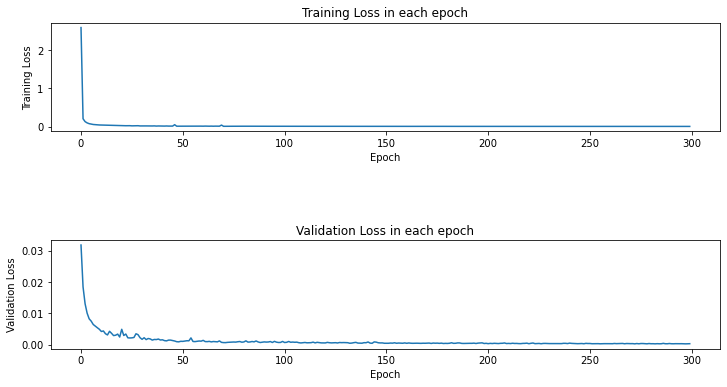

In [11]:
file1 = open(training_data_path, 'r')
Lines = file1.readlines()

training_data_list = []
for line in Lines:
    training_data_list.append([float(x) for x in line.strip().split('/')])
    
# Plot the Training loss and validation loss during training
plt.figure(figsize=(12, 6))
    
plt.subplot(2, 1, 1)
plt.plot(training_data_list[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss in each epoch')

plt.subplot(2, 1, 2)
plt.plot(training_data_list[1])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss in each epoch')
    
plt.subplots_adjust(hspace=1)
    
plt.show()

Total loss for the model is 0.000249787044367622
Accuracy for the model is 100

Best model has a error of  1.5838304534554482e-06


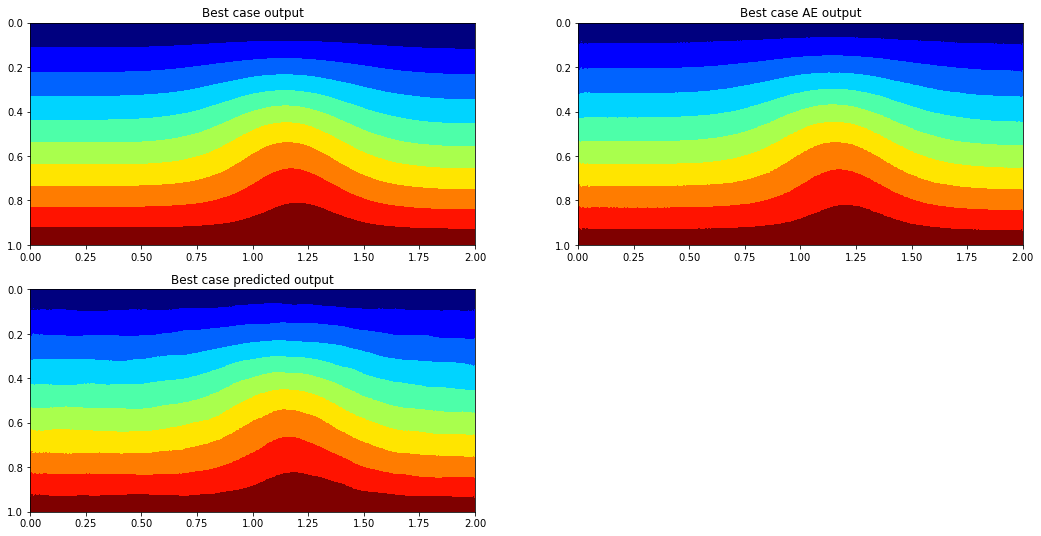

Worst model has a error of  1.3970125110063236e-05


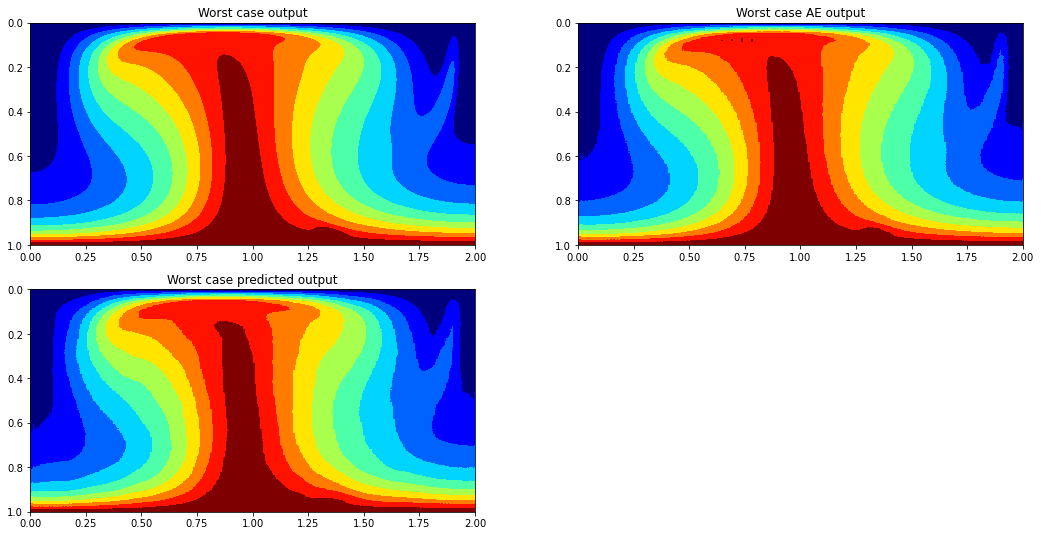

In [12]:
model = Net().to(device)
test(model, encoder, decoder, test_loader, device)

Total loss for the model is 0.0019860902170876216
Accuracy for the model is 100

Best model has a error of  1.5632551821909146e-06


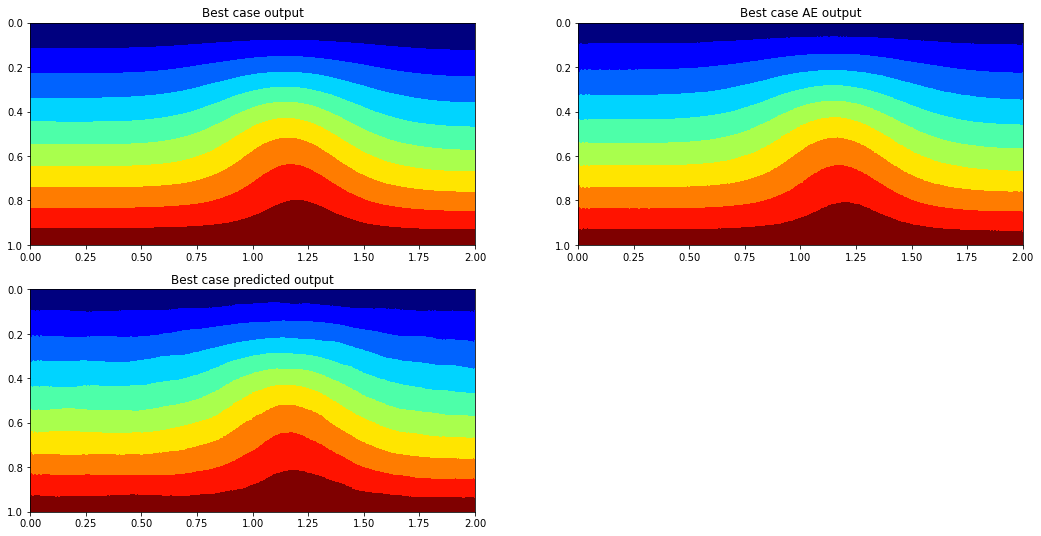

Worst model has a error of  1.8083561371895485e-05


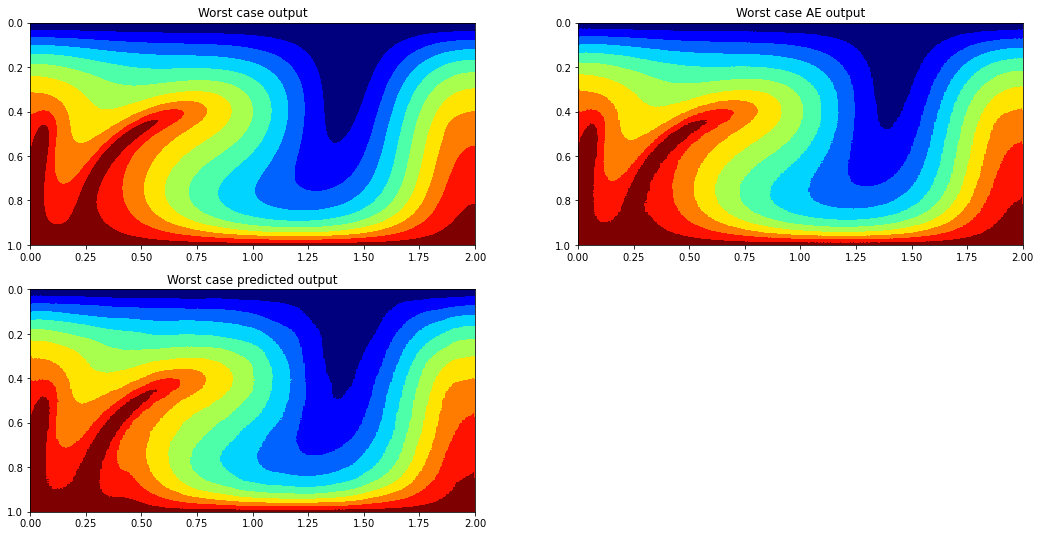

In [13]:
test(model, encoder, decoder, train_loader, device)

In [44]:
# Test for a complete cycle of timestamps

# Index for the testing file
testing_file_index = 5

# Read the testing file
testing_temperature_fields = []
testing_file_path = path + "/solution_" + str(testing_file_index) +".h5"
with h5py.File(testing_file_path, 'r') as f:
    testing_temperature_fields = f['temperature'][:]

# Looping through the NN
predicted_temperature_fields = [testing_temperature_fields[0]]

testing_input = torch.from_numpy(testing_temperature_fields[0])
testing_latentSpace = encoder(testing_input.view(1, 1, 201, 401))
for i in range(99):
    testing_latentSpace = model(testing_latentSpace)
    predicted_temperature_fields.append(decoder(testing_latentSpace).detach().numpy()[0][0])

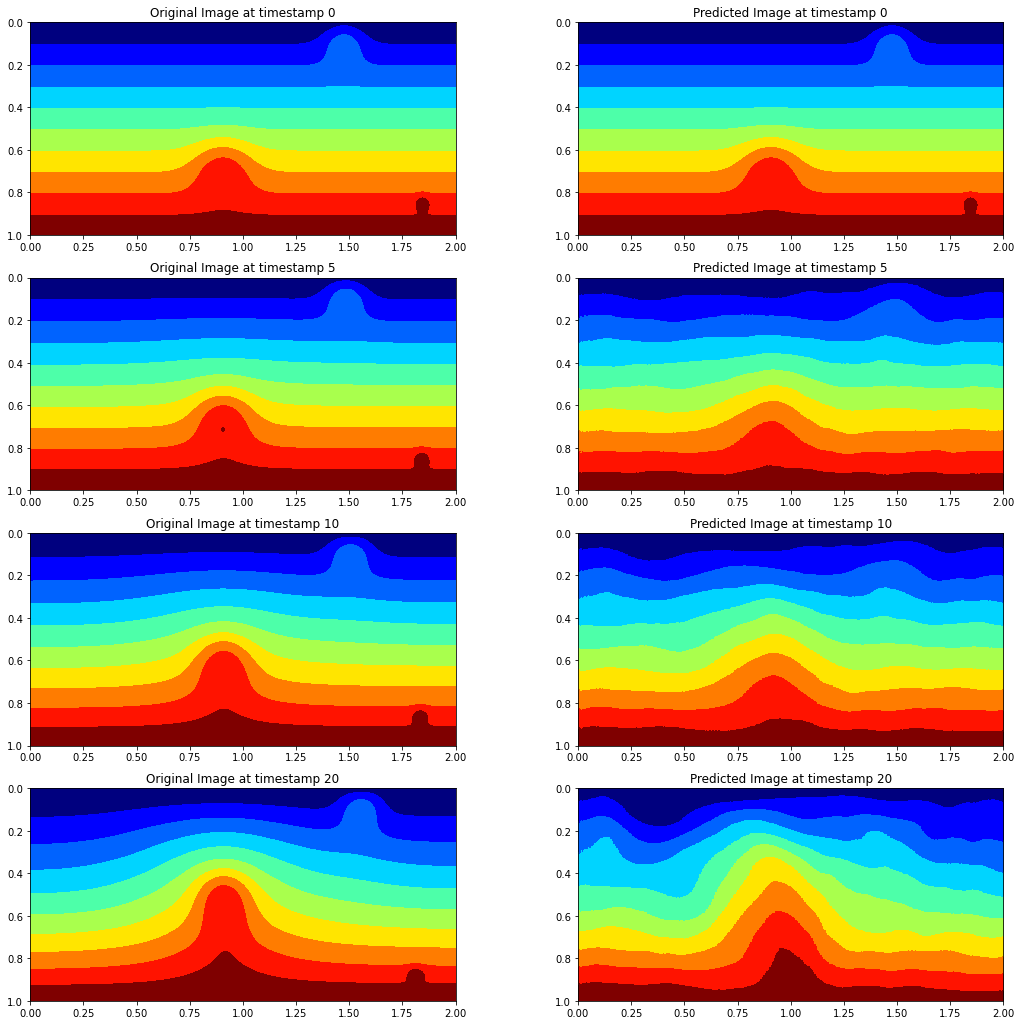

In [47]:
# Timestamps we want to test with
testing_timestamps = [0,5,10,20]

# Plotting
plt.figure(figsize=(18, 18))
    
plt.subplot(4,2,1)
plt.title("Original Image at timestamp {}".format(testing_timestamps[0]))
plt.imshow(testing_temperature_fields[testing_timestamps[0]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
    
    
plt.subplot(4,2,2)
    
plt.title("Predicted Image at timestamp {}".format(testing_timestamps[0]))
plt.imshow(predicted_temperature_fields[testing_timestamps[0]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


plt.subplot(4,2,3)
plt.title("Original Image at timestamp {}".format(testing_timestamps[1]))
plt.imshow(testing_temperature_fields[testing_timestamps[1]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
    
    
plt.subplot(4,2,4)
    
plt.title("Predicted Image at timestamp {}".format(testing_timestamps[1]))
plt.imshow(predicted_temperature_fields[testing_timestamps[1]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


plt.subplot(4,2,5)
plt.title("Original Image at timestamp {}".format(testing_timestamps[2]))
plt.imshow(testing_temperature_fields[testing_timestamps[2]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
    
    
plt.subplot(4,2,6)
    
plt.title("Predicted Image at timestamp {}".format(testing_timestamps[2]))
plt.imshow(predicted_temperature_fields[testing_timestamps[2]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


plt.subplot(4,2,7)
plt.title("Original Image at timestamp {}".format(testing_timestamps[3]))
plt.imshow(testing_temperature_fields[testing_timestamps[3]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
    
    
plt.subplot(4,2,8)
    
plt.title("Predicted Image at timestamp {}".format(testing_timestamps[3]))
plt.imshow(predicted_temperature_fields[testing_timestamps[3]],
           cmap=cm.get_cmap('jet', 10),
           extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
    
    
plt.show()